In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
coin=input("Enter a coin code:")
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
if(coin=='BTC'):
    res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='ETH'):
    res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='XRP'):
    res = requests.get(endpoint + '?fsym=XRP&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='ADA'):
    res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=500')
    data=json.loads(res.content)['Data']
elif(coin=='VET'):
    res = requests.get(endpoint + '?fsym=VET&tsym=USD&limit=500')
    data=json.loads(res.content)['Data'] 
elif(coin=='BNB'):
    res = requests.get(endpoint + '?fsym=BNB&tsym=USD&limit=500')
    data=json.loads(res.content)['Data'] 
else:
    print("Enter any of these coins(Bitcoin[BTC]/Ethereum[ETH]/Ripple[XRP]/Cardano[ADA]/VeChain[VET]/Binance Coin[BNB]")
    input("Enter a coin code:")

Enter a coin code:BTC


In [ ]:
for element in data:
  element.pop('conversionType',None)
  element.pop('conversionSymbol',None)
hist = pd.DataFrame(data)
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
hist["high"]=hist["high"]*74.32
hist["low"]=hist["low"]*74.32
hist["open"]=hist["open"]*74.32
hist["close"]=hist["close"]*74.32
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.float_format = '{:.5f}'.format
target_col = 'close'

In [ ]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-11-08,5035585.78720,4704662.60960,4704662.60960,39774.17000,2614939972.01000,5020252.08480
2021-11-09,5091979.80320,4928339.05440,5020252.08480,32745.53000,2209551778.82000,4974924.31680
2021-11-10,5126492.52480,4696745.30000,4974924.31680,50591.31000,3365466815.36000,4825304.77920
2021-11-11,4874327.73760,4766169.09840,4825304.77920,21475.67000,1393819061.45000,4817481.85600
2021-11-12,4865433.12000,4765550.75600,4817481.85600,5370.30000,348509628.35000,4813235.95440


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [INR]]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

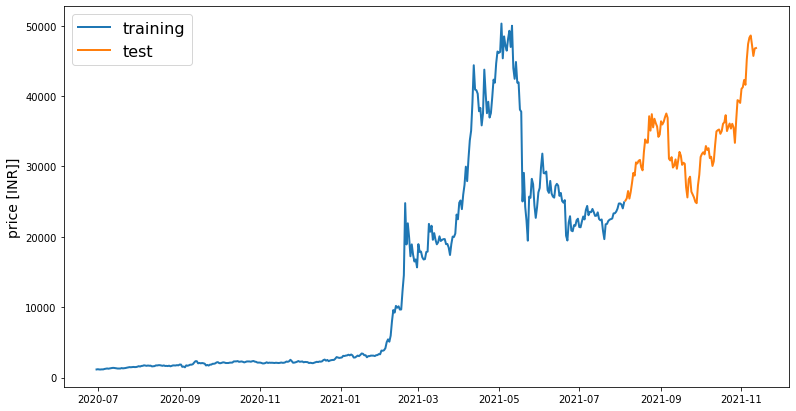

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist,target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 37ms/step - loss: 0.0256 - val_loss: 0.0069
Epoch 2/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0064
Epoch 3/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0060
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0053
Epoch 5/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0050
Epoch 6/20
13/13 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0047
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0048
Epoch 8/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0042
Epoch 9/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 10/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0040
Epoch 11/20
13/13 

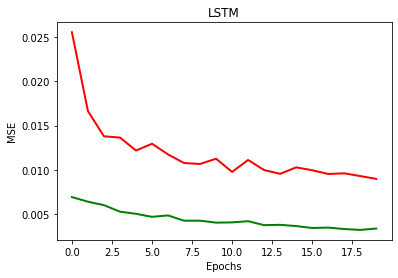

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.0442671954902809

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.0033505023527341765

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6875903571895833

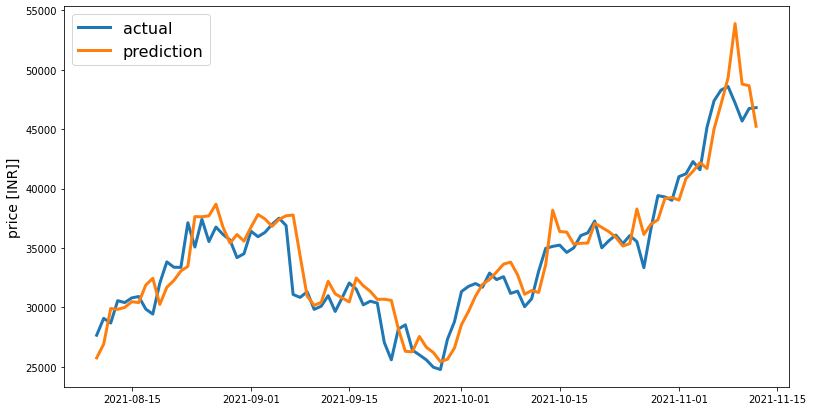

In [ ]:
preds = test[target_col].values[:-window_len] * (preds+1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)